# SAM Model

3/26/2025

-Create more customizations

ref https://mrcreamio.wordpress.com/2023/04/14/how-to-use-segment-anything-modelsam-python/


Import libraries

In [ ]:
import numpy as np
import pandas as pd

import os
import sys
sys.path.append("..")
import pathlib
from pathlib import Path

import cv2
import PIL
from PIL import Image

import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


Load images

In [ ]:

#input folder paths
input_path_mut = '/home/ascott10/documents/school/capstone/mutant'
input_path_wt = '/home/ascott10/documents/school/capstone/wt'

#Retrieve files
image_filepaths_mut = []
image_filepaths_wt = []

for files in os.listdir(input_path_mut):
    if files.endswith('png'):
        image_filepaths_mut.append(os.path.join(input_path_mut,files))
        

for files in os.listdir(input_path_wt):
    if files.endswith('png'):
        image_filepaths_wt.append(os.path.join(input_path_wt,files))
        

#wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Loading the pretrained SAM model

In [ ]:
# Load the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"  # Pre-downloaded the model already to my folder
model_type = "vit_h"  # model type is vit_h per the pre-downloaded model

device = "cuda" if torch.cuda.is_available() else "cpu" 

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device)
sam.to(device=device)


Configuring the automatic mask generator

In [3]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,                              #pretrained model to generate masks
    points_per_side=32,                     #number of points to be sampled per side of image (more points = denser sampling ~ better segmentation)
    pred_iou_thresh=0.9,                    #predicted Intersection over Union (IoU) threshold. higher IoU --> higher quality
    stability_score_thresh=0.96,            #stability score = measure of quality ~ higher --> better quality masks
    crop_n_layers=1,                        # #layers of crops --> size of image crops, improve performance on smaller objects
    crop_n_points_downscale_factor=2,       # downscaling factor for #points per side in the crops, controls density of point sampling in the image crops
    min_mask_region_area=100,               #min area of a mask region to be considered valid, masks with smaller area will be discarded
)

Generate the masks


In [ ]:
#sample image

image_orig = cv2.imread(image_filepaths_mut[0]) #input is image path
image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

masks = mask_generator_.generate(image)
print(len(masks))

5


Display the masks

-Define a helper function show_anns to display the generated masks overlaid the input image

In [9]:
def show_anns(anns):
    if len(anns) == 0: #if there are no masks do nothing
        return
    
    #else sort the masks by area, largest first
    sorted_anns = sorted(anns, key = lambda x: x['area'], reverse = True)

    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))





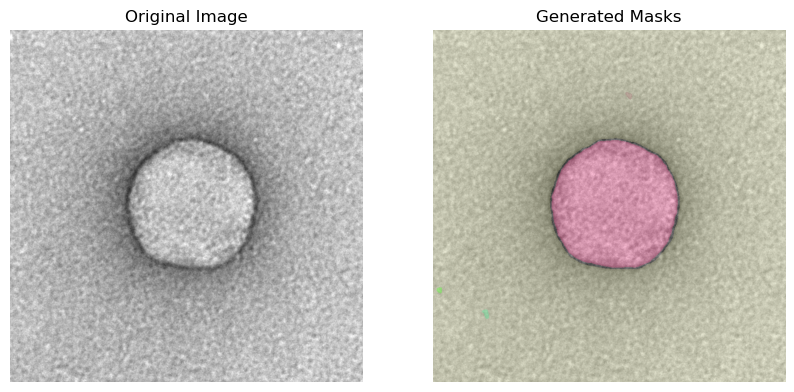

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(image)
show_anns(masks)
ax[1].set_title('Generated Masks')
ax[1].axis('off')
plt.show()

#write to file to see output to be able to use cluster

In [12]:
def sam_workflow(im_path):

    image_orig = cv2.imread(im_path) #input is image path
    image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)

    height, width = image.shape[:2]
    image_center = np.array([width // 2, height // 2])

    #Create empty image of same shape as image with zeros in range [0,255]
    segmentation_map = np.zeros((height, width, 3), dtype=np.uint8)

    #Make the mask from the sam model
    masks = mask_generator_.generate(image)

    
    #compute area
    for mask in masks:
        # Function to compute mask area
        def get_mask_area(mask):
            return np.sum(mask["area"])

        def get_center_distance(mask):
            x, y, w, h = mask["bbox"]  # Get bounding box of the mask
            mask_center = np.array([x + w // 2, y + h // 2])  # Compute mask center
            return np.linalg.norm(mask_center - image_center)  # Euclidean distance

    #Sort masks by euclidean distance then by area 
    masks.sort(key=get_center_distance)  # Then sort by closeness to center
    masks.sort(key=get_mask_area, reverse=True)  # Sort by area (largest first)
    
    

    ####Spikes#####
    spike = 0 #Spike counter

    ####Body#####
    # Assign the first mask (most centered large object) as "body", rest as "spikes"
    x_body, y_body, w_body, h_body  = masks[1]['bbox']
    extend = 50 #Create box around the body to include the spikes
    x_xten, y_xten, w_xten, h_xten = (x_body-extend),(y_body-extend),(w_body+(2*extend)),(h_body+2*extend)

    #Temporary storage of x and y coordinates for specified range
    x_coords = []
    y_coords = []
    h_coords = []
    w_coords = []
    for i, mask in enumerate(masks):
        if i == 0: 
            #The largest mask (first in sorted) is the background
            segmentation_map[mask["segmentation"] > 0] = (0, 0, 255) #blue
        else:
            if i == 1:
                #The second largest mask is center body
                segmentation_map[mask["segmentation"] > 0] = (128, 0, 128) #purple
            
            else:
                x, y, w, h = mask["bbox"] #Grab the coordinates of the spike
                if (x > x_xten) and (x < (x_xten+h_xten)) and (y > y_xten) and (y < (y_xten+w_xten)): #if in range
                    spike = spike + 1 #Add to the counter
                    #make a list of the x-coordinates(first number)
                    x_coords.append(x)                
                    y_coords.append(y)                    
                    h_coords.append(h)                   
                    w_coords.append(w)
                    #The rest of the masks will be the spikes
                    segmentation_map[mask["segmentation"] > 0] = (0, 255, 0) #green
                
                #if the bbox outside range of bbox of extended body
                #then it will not count as a spike             
                
                else:
                    spike = spike
                    segmentation_map[mask["segmentation"] > 0] = (127,127,127) #gray it out

    #########Visualization###########
    # Blend the original image with the mask overlay
    blended = cv2.addWeighted(image, 0.5, segmentation_map, 0.5, 0)

    return image_orig, blended, spike

        
    #print(f'Number of spikes: {spike}')

    #plt.figure(figsize=(3,3))
    #plt.imshow(blended)

    #Rectangle for where the body and spikes are being counted
    #plt.gca().add_patch(Rectangle((x_xten,y_xten),(w_xten),(h_xten), fill = False))
    #for k in range(0,len(x_coords)):
        #plt.gca().add_patch(Rectangle((x_coords[k],y_coords[k]),w_coords[k],h_coords[k], fill = False))
    #plt.axis('off')
        
    #plt.show()


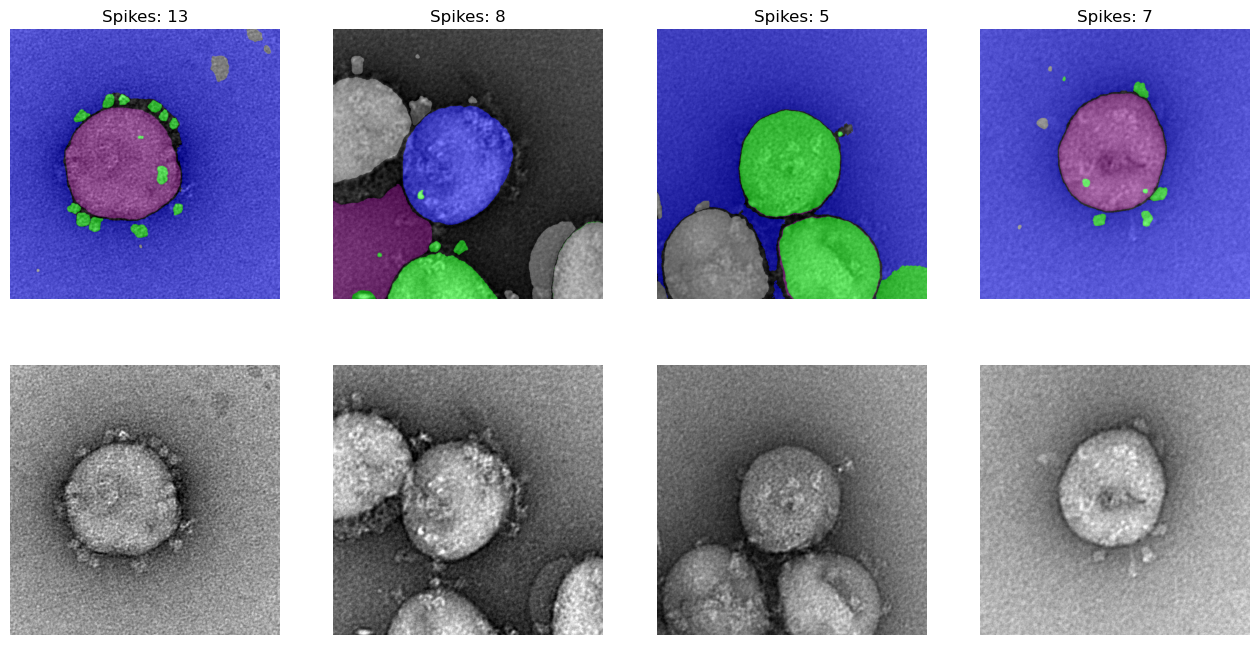

In [14]:
import random 
blend_list = []
spike_list = []
image_list = []

n = 4  # Number of random numbers
rand_ = random.sample(range(1, 400), n)

for i in range(0, len(rand_)):
    index = rand_[i]
    image, blended, spikes = sam_workflow(image_filepaths_wt[index]) #input is random image from list of filepaths
    blend_list.append(blended)
    spike_list.append(spikes)
    image_list.append(image)

num_plots = n #max number of plots
                       

cols = num_plots
rows = 2


fig,axes = plt.subplots(2,num_plots, figsize = (4*cols, 4*rows))


for k in range(0,len(blend_list)):
    axes[0,k].imshow(blend_list[k],cmap = 'gray')
    axes[0,k].set_title(f'Spikes: {spike_list[k]}')
    axes[0,k].axis('off')
for j in range(0,len(image_list)):
    axes[1,j].imshow(image_list[j],cmap = 'gray')
    axes[1,j].axis('off')

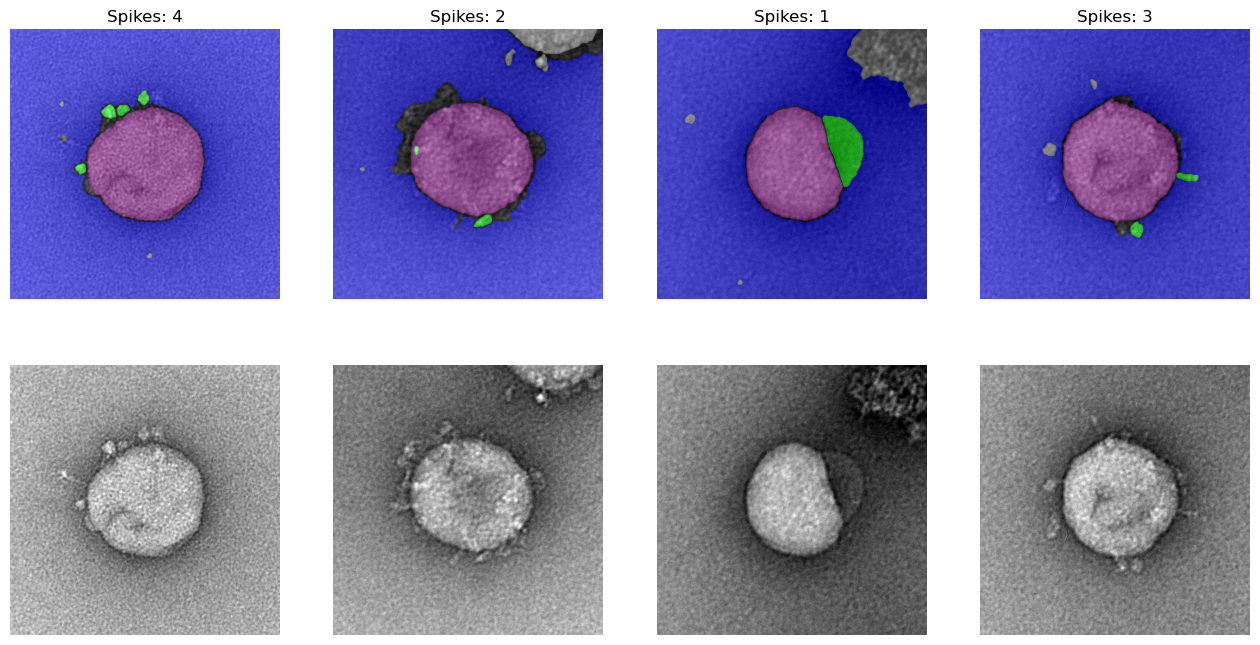

In [15]:
import random 
blend_list = []
spike_list = []
image_list = []

n = 4  # Number of random numbers
rand_ = random.sample(range(1, 400), n)

for i in range(0, len(rand_)):
    index = rand_[i]
    image, blended, spikes = sam_workflow(image_filepaths_wt[index]) #input is random image from list of filepaths
    blend_list.append(blended)
    spike_list.append(spikes)
    image_list.append(image)

num_plots = n #max number of plots
                       

cols = num_plots
rows = 2


fig,axes = plt.subplots(2,num_plots, figsize = (4*cols, 4*rows))


for k in range(0,len(blend_list)):
    axes[0,k].imshow(blend_list[k],cmap = 'gray')
    axes[0,k].set_title(f'Spikes: {spike_list[k]}')
    axes[0,k].axis('off')
for j in range(0,len(image_list)):
    axes[1,j].imshow(image_list[j],cmap = 'gray')
    axes[1,j].axis('off')

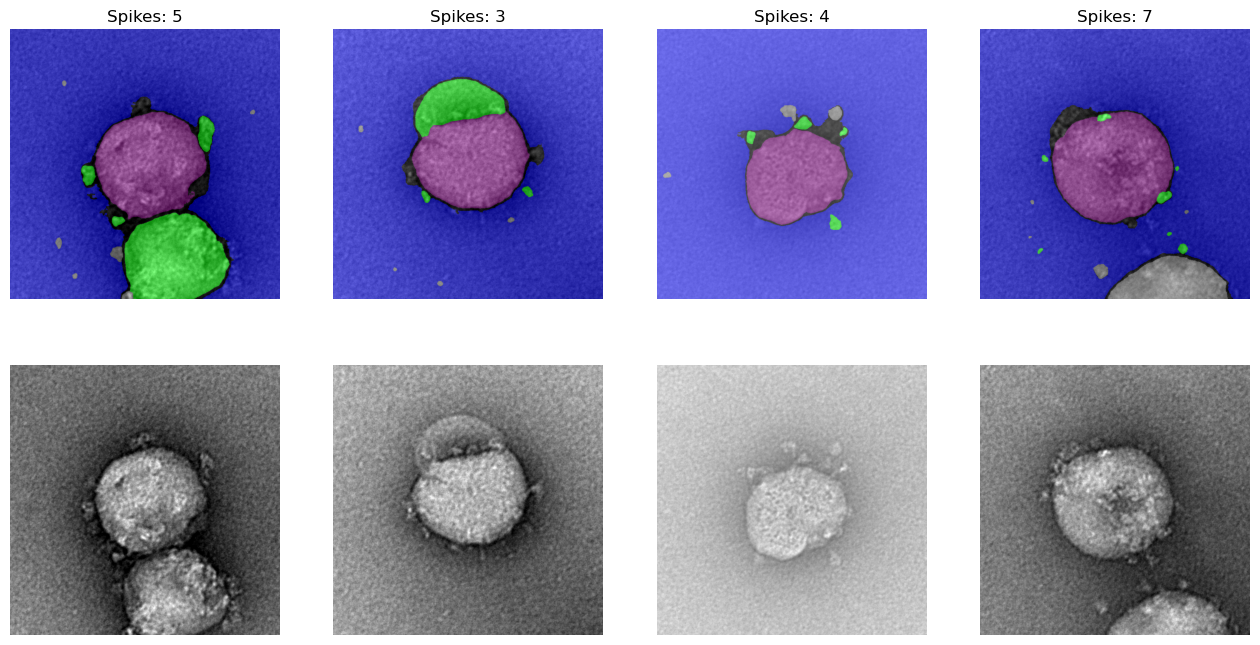

In [16]:
import random 
blend_list = []
spike_list = []
image_list = []

n = 4  # Number of random numbers
rand_ = random.sample(range(1, 400), n)

for i in range(0, len(rand_)):
    index = rand_[i]
    image, blended, spikes = sam_workflow(image_filepaths_wt[index]) #input is random image from list of filepaths
    blend_list.append(blended)
    spike_list.append(spikes)
    image_list.append(image)

num_plots = n #max number of plots
                       

cols = num_plots
rows = 2


fig,axes = plt.subplots(2,num_plots, figsize = (4*cols, 4*rows))


for k in range(0,len(blend_list)):
    axes[0,k].imshow(blend_list[k],cmap = 'gray')
    axes[0,k].set_title(f'Spikes: {spike_list[k]}')
    axes[0,k].axis('off')
for j in range(0,len(image_list)):
    axes[1,j].imshow(image_list[j],cmap = 'gray')
    axes[1,j].axis('off')

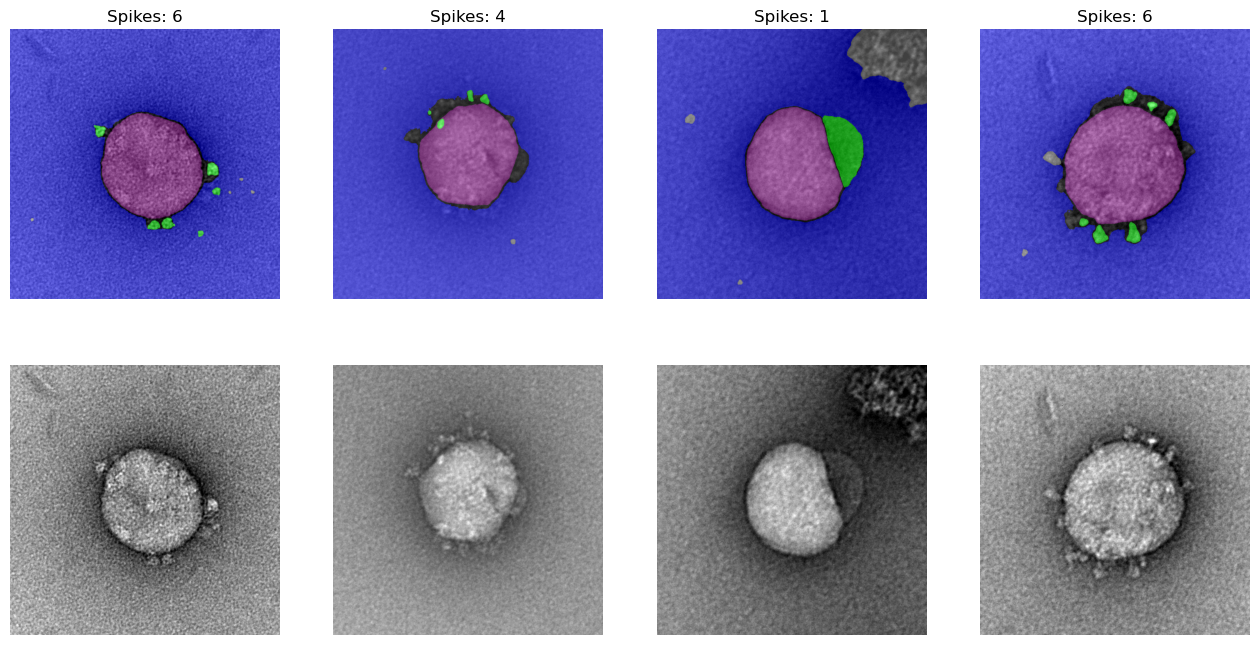

In [17]:
import random 
blend_list = []
spike_list = []
image_list = []

n = 4  # Number of random numbers
rand_ = random.sample(range(1, 400), n)

for i in range(0, len(rand_)):
    index = rand_[i]
    image, blended, spikes = sam_workflow(image_filepaths_wt[index]) #input is random image from list of filepaths
    blend_list.append(blended)
    spike_list.append(spikes)
    image_list.append(image)

num_plots = n #max number of plots
                       

cols = num_plots
rows = 2


fig,axes = plt.subplots(2,num_plots, figsize = (4*cols, 4*rows))


for k in range(0,len(blend_list)):
    axes[0,k].imshow(blend_list[k],cmap = 'gray')
    axes[0,k].set_title(f'Spikes: {spike_list[k]}')
    axes[0,k].axis('off')
for j in range(0,len(image_list)):
    axes[1,j].imshow(image_list[j],cmap = 'gray')
    axes[1,j].axis('off')

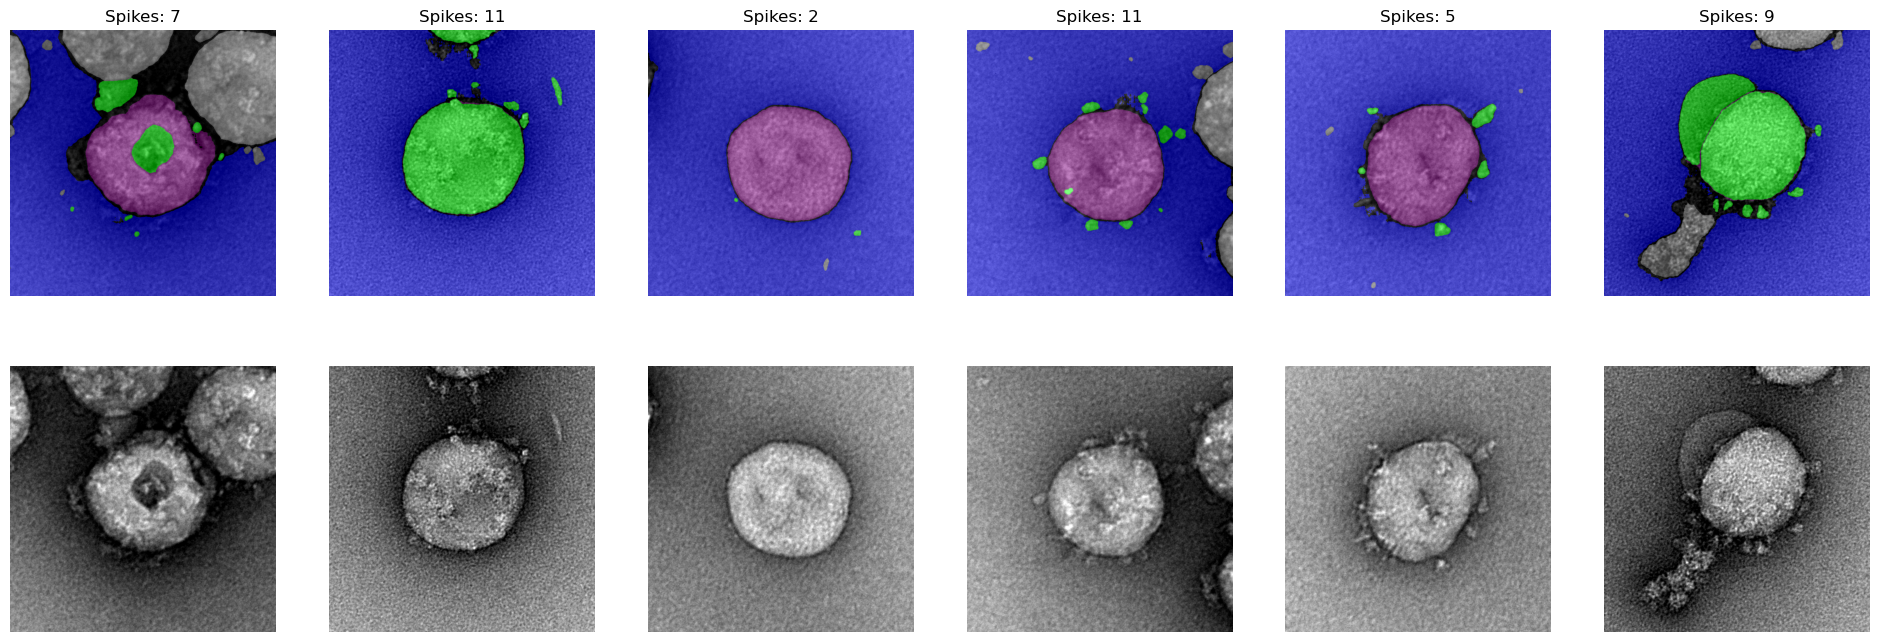

In [10]:
import random 
blend_list = []
spike_list = []
image_list = []

n = 6  # Number of random numbers
rand_ = random.sample(range(1, 400), n)

for i in range(0, len(rand_)):
    index = rand_[i]
    image, blended, spikes = sam_workflow(image_filepaths_wt[index])
    blend_list.append(blended)
    spike_list.append(spikes)
    image_list.append(image)

num_plots = n #max number of plots
                       

cols = num_plots
rows = 2


fig,axes = plt.subplots(2,num_plots, figsize = (4*cols, 4*rows))


for k in range(0,len(blend_list)):
    axes[0,k].imshow(blend_list[k],cmap = 'gray')
    axes[0,k].set_title(f'Spikes: {spike_list[k]}')
    axes[0,k].axis('off')
for j in range(0,len(image_list)):
    axes[1,j].imshow(image_list[j],cmap = 'gray')
    axes[1,j].axis('off')